### Building and Evaluating ARMA Models

The main task here is to pick a time series of interest, fit an ARMA model to it, make a basic forecast, and then assess
how well it performs by analyzing the errors. It’s also a good idea to experiment with a few different combinations of
$p$ and $q$, since ACF and PACF plots are only rough guides. Running a small grid search often helps find better parameter values.

For this exercise, I worked with the [Production and sales of cement bags](https://indicadores.pr/dataset/f1b1d002-5958-431a-abfe-539ce3814018/resource/806d9de9-c2ee-4506-b6fc-ed2990a54561/download/datos_cemento.csv)
, which contains monthly data on the production and sales of 94 lb sacks of cement in Puerto Rico.


## Production and sales of cement bags
#### Data Description:
The data contains three columns: `Date`, `Production`, and `Sales`. For this exercise, I will focus on forecasting the `Sales` column, which represents the number of cement bags sold each month. The goal is to build an ARMA, ARIMA, SARIMA, or SARIMAX model to forecast future sales and evaluate the model's performance.

The `Production` recording started in January 2007  and the `Sales` recording started in July 1998. For this exercise, I will work from data starting in January 2007, which gives us a consistent time frame for both production and sales.

**Source:** Government Development Bank (BGF).

Since 1959, the BGF has collected monthly information on the production and sales of companies that produce 94‑pound cement bags in Puerto Rico. At present, these are: CEMEX, ESSROC, and Argos. This information is aggregated and published by the BGF. Note: Sales of cement bags that occur in retail stores are not included, nor are cement bags imported into Puerto Rico included.


## Time Series Models

The first step is to load the data and preprocess it, including handling any missing values and ensuring that the date column is in the correct format for time series analysis. After that, I will explore the data, visualize it, and then proceed to fit different models to the sales data. Finally, I will evaluate the model's performance using appropriate metrics such as mean squared error (MSE) and mean absolute error (MAE).

To summarize, the steps are as follows:
1. Load and preprocess the data.
2. Explore and visualize the sales data.
3. Fit multiple models to the sales data.
4. Make forecasts of Sales using the fitted model.
5. Evaluate the model's performance using MSE and MAE.

In [1]:
# Import Libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [2]:
# Load data train data
df = pd.read_csv('./data/datos_cemento.csv')
df.head()


,Date,Production,Sales
0,12/1/2025,673242.0,1175442.649
1,11/1/2025,731303.0,1176428.391
2,10/1/2025,779872.0,1386078.940
3,9/1/2025,634802.0,1229262.336
4,8/1/2025,812366.0,1324978.434


In [3]:
df.tail()

,Date,Production,Sales
325,11/1/1998,NaN,3259000.0
326,10/1/1998,NaN,3070000.0
327,9/1/1998,NaN,2447000.0
328,8/1/1998,NaN,3258000.0
329,7/1/1998,NaN,3700000.0


### Preprocessing

In [4]:
# production started in Jan 2007.
df.isna().sum()

Date            0
Production    102
Sales           0
dtype: int64

In [5]:
# Drop na values
df.dropna(inplace=True)

In [6]:
df.isna().sum()

Date          0
Production    0
Sales         0
dtype: int64

In [7]:
# Should have data starting in Jan 2007
print(df.head())
print(df.tail())

        Date  Production        Sales
0  12/1/2025    673242.0  1175442.649
1  11/1/2025    731303.0  1176428.391
2  10/1/2025    779872.0  1386078.940
3   9/1/2025    634802.0  1229262.336
4   8/1/2025    812366.0  1324978.434
         Date  Production      Sales
223  5/1/2007   2912950.0  3535506.0
224  4/1/2007   2438980.0  2874418.0
225  3/1/2007   3242360.0  3530070.0
226  2/1/2007   2810360.0  3103919.0
227  1/1/2007   2338910.0  2896660.0


In [8]:
# Change date column to datetime and update index to Date
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Sort descending order by date
df.sort_index(inplace=True)
# Set frequency
df.index.freq = 'MS' # Monty Start
df

,Production,Sales
Date,,
2007-01-01,2338910.0,2896660.000
2007-02-01,2810360.0,3103919.000
2007-03-01,3242360.0,3530070.000
2007-04-01,2438980.0,2874418.000
2007-05-01,2912950.0,3535506.000
...,...,...
2025-08-01,812366.0,1324978.434
2025-09-01,634802.0,1229262.336
2025-10-01,779872.0,1386078.940


#### Sales and Production Distribution

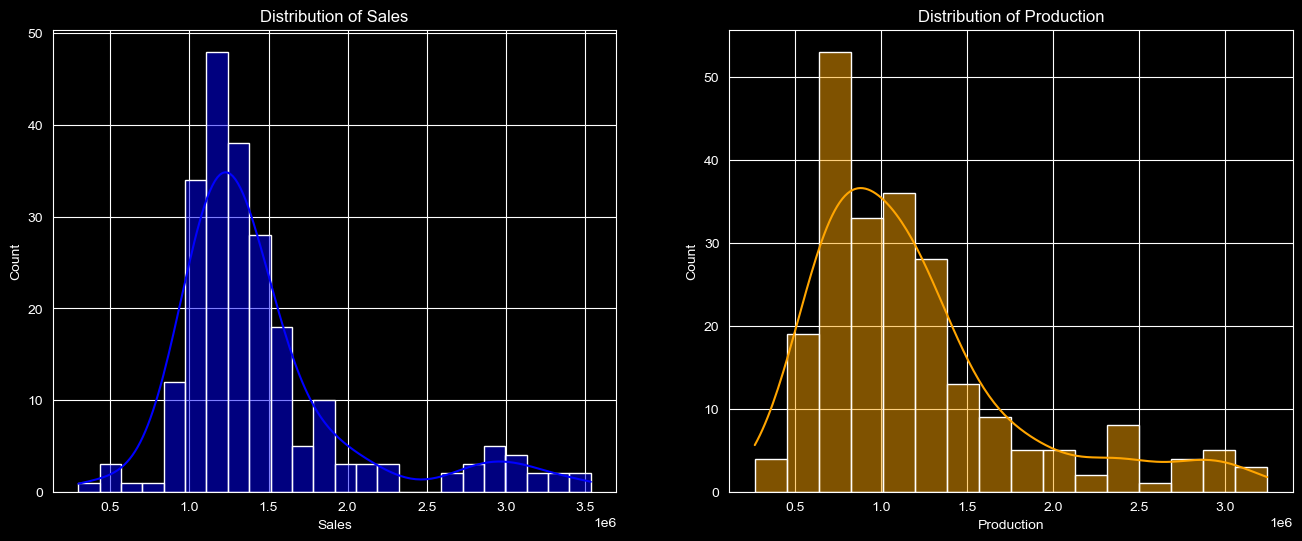

In [9]:
 # Plot sales and production distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Sales'], ax=ax[0], kde=True, color='blue')
ax[0].set_title('Distribution of Sales')
sns.histplot(df['Production'], ax=ax[1], kde=True, color='orange')
ax[1].set_title('Distribution of Production')
plt.show()

#### Interpretation

The distribution of sales appears to be right-skewed, with a long tail towards higher sales values. This suggests that there are some months with significantly higher sales compared to the majority of the data. The distribution of production also appears to be right-skewed, but it is less pronounced than the sales distribution. Both distributions indicate that there may be outliers or extreme values in the data, which could impact the modeling process. It may be necessary to consider log tranformation technique to handle the skewness in the data before fitting the models.

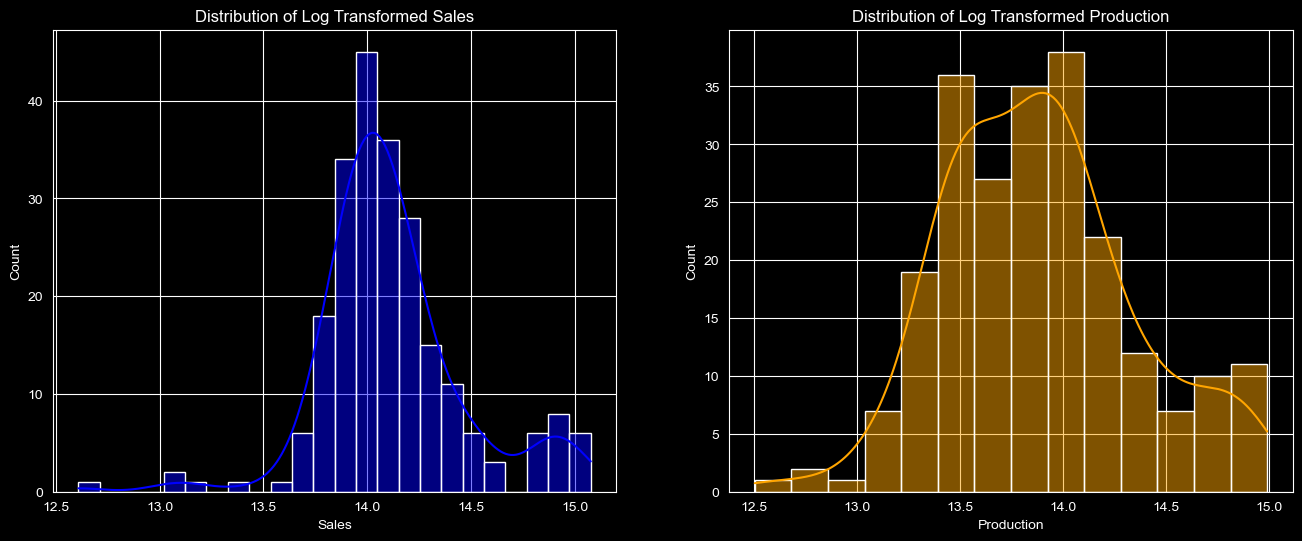

In [10]:
# Apply log transformation to handle skewness
# Plot log transformed sales and production distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(np.log(df['Sales']), ax=ax[0], kde=True, color='blue')
ax[0].set_title('Distribution of Log Transformed Sales')
sns.histplot(np.log(df['Production']), ax=ax[1], kde=True, color='orange')
ax[1].set_title('Distribution of Log Transformed Production')

plt.show()

#### Interpretation

The distribution of log transformed sales appears to be more symmetric shape. This suggests that the log transformation has effectively reduced the skewness in the sales data. The distribution of log transformed production also appears to be more symmetric, but it is still slightly skewed to the right. This indicates that the log transformation has helped to stabilize the variance in the production data, which can be beneficial for modeling.

#### Split data into train and test sets

Data from Jan 2007 to Dec 2020 will be used for training, and data from Jan 2021 to Dec 2025 will be used for testing. This allows us to evaluate the model's performance on unseen data while still having a significant amount of data for training.

In [11]:
df.tail()

,Production,Sales
Date,,
2025-08-01,812366.0,1324978.434
2025-09-01,634802.0,1229262.336
2025-10-01,779872.0,1386078.940
2025-11-01,731303.0,1176428.391
2025-12-01,673242.0,1175442.649


In [12]:
#### Split data into train and test sets
df_train = df[df.index < '2021-01-01']
df_test = df[df.index >= '2021-01-01']
print(f'Training data range: {df_train.index.min()} to {df_train.index.max()}')
print(f'Testing data range: {df_test.index.min()} to {df_test.index.max()}')

Training data range: 2007-01-01 00:00:00 to 2020-12-01 00:00:00
Testing data range: 2021-01-01 00:00:00 to 2025-12-01 00:00:00


### Exploratory Data Analysis

In [13]:
# Function to plot sales

fig = go.Figure()

# plot original Sales column
fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['Sales'],
    mode='lines+markers',
    name='Sales',
    line=dict(color='#636EFA'),
    marker=dict(color='#636EFA')))

# plot config
fig.update_layout(
    title='Monthly Sales of Cement Bags in Puerto Rico',
    xaxis_title='Date',
    yaxis_title='Number of Cement Bags Sold',
    template='plotly_white',
    hovermode='x'
)

fig.show()


In [14]:
# Plot log transformed sales

fig = go.Figure()

# plot original Sales column
fig.add_trace(go.Scatter(
    x=df_train.index,
    y=np.log(df_train['Sales']),
    mode='lines+markers',
    name='Log(Sales)',
    line=dict(color='#636EFA'),
    marker=dict(color='#636EFA')))

# plot config
fig.update_layout(
    title='Log(Monthly Sales of Cement Bags in Puerto Rico)',
    xaxis_title='Date',
    yaxis_title='Log of Sales',
    template='plotly_white',
    hovermode='x'
)

fig.show()


#### Interpretation
This series shows trends and seasonality indicating non stationary, may need to consider differencing or seasonal components in our model. Will do stationarity test using the Augmented Dickey-Fuller test (ADF test) and also look at the ACF and PACF plots to determine potential values for p and q.

### Stationarity Test (ADF Test)

In [15]:
# ADF test on raw data
adf_stat, p_value, *_ = adfuller(df_train['Sales'])
print(f'ADF Statistic raw data: {adf_stat}')
print(f'p-value raw data: {p_value}')
print('***')
# ADF test on log transformed data
adf_stat_log, p_value_log, *_ = adfuller(np.log(df_train['Sales']))
print(f'ADF Statistic for log transformed data: {adf_stat_log}')
print(f'p-value for log transformed data: {p_value_log}')

ADF Statistic raw data: -3.5088977762165423
p-value raw data: 0.007761499246456593
***
ADF Statistic for log transformed data: -2.7209981462880544
p-value for log transformed data: 0.07047462177160226


### Interpretation
The p value for raw data is 0.0078, p < 0.05, the test rejects the null hypothesis, the series is stationary. The p value for log transformed data is 0.07, p > 0.05, the test fails to reject the null hypothesis, the log transformed series is not stationary. I will proceed with the raw data for modeling since it is already stationary.

#### ACF and PACF Analysis

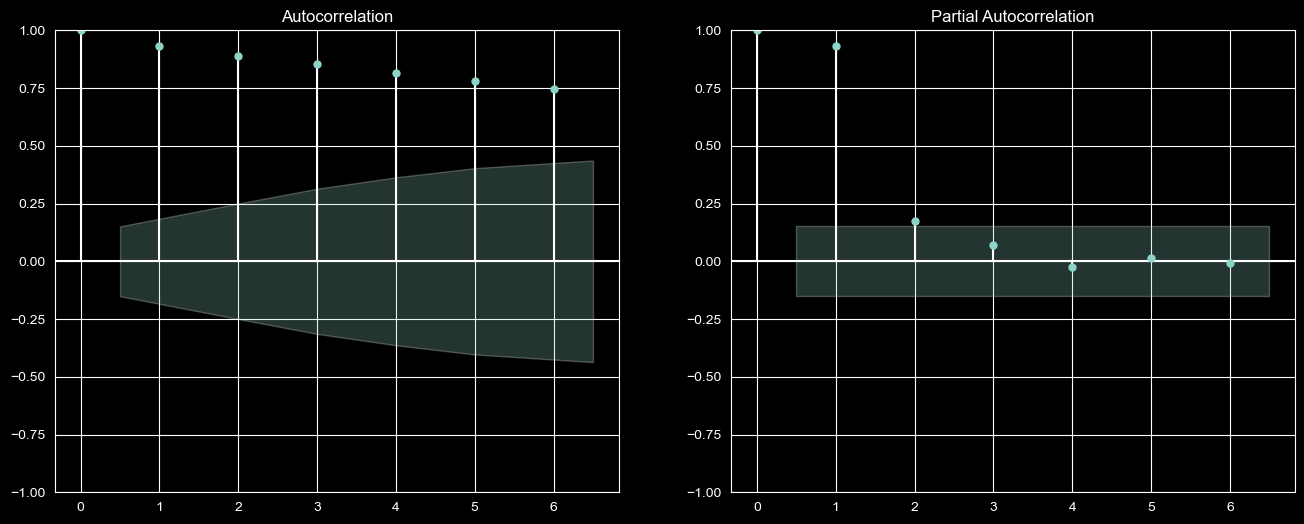

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_train['Sales'], ax=ax[0], lags=6)
plot_pacf(df_train['Sales'], ax=ax[1], lags=6,)

plt.show()


#### Interpretation

The ACF starts high at lag 1 and then slowly decreases. This slow decay indicates an autoregressive (AR) process, where past values influence future values beyond just lag 1. The PACF shows a significant spike at lag 1 and then cuts off sharply, which suggest and AR(1) process, the current value is strongly dependent on the immediately previous value, but not on values further back in time. Based on this analysis, I will start by fitting an AR(1) model to the sales data and evaluate its performance.


#### Rules for identifying p and q from ACF and PACF plots

| ACF Pattern | PACF Pattern | Model | p | q |
|---|---|---|---|---|
| Sharp cutoff after lag *q* | Slow/gradual decay | Pure MA(q) | 0 | Number of significant ACF lags |
| Slow/gradual decay | Sharp cutoff after lag *p* | Pure AR(p) | Number of significant PACF lags | 0 |
| Sharp cutoff after lag *q* | Sharp cutoff after lag *p* | Mixed ARMA(p,q) | Number of significant PACF lags | Number of significant ACF lags |`
| Both decay gradually | Both decay gradually | Mixed ARMA(p,q) | Try small values & compare AIC/BIC | Try small values & compare AIC/BIC |
| Both cut off at lag 0 | Both cut off at lag 0 | White noise | 0 | 0 |

Based on this analysis, I will start by fitting an `ARMA(p,q)`=`ARMA(1,0)`= `ARIMA(1,0,0)`= `ARIMA(p,d,q)` model to the differenced sales data and evaluate its performance.

Below table is a summary of the different models I will fit to the data, along with their corresponding parameters and the data used for fitting:

| ARIMA Model | p | d | q | Data Used                         | Stationarity Condition                              |
|:-----------:|:-:|:-:|:-:|:---------------------------------:|:---------------------------------------------------:|
| AR          | 1 | 0 | 0 | Original (Sales)                  | Stationary (ADF p-value = 0.008, no differencing)    |
| MA          | 0 | 0 | 1 | Original (Sales)                  | Stationary (ADF p-value = 0.008, no differencing)    |
| ARMA        | 2 | 0 | 1 | Original (Sales)                  | Stationary (ADF p-value = 0.008, no differencing)    |
| ARIMA       | 2 | 1 | 2 | Original (Sales)                  | Model applies 1 order of differencing (d=1)          |
| ARIMAX      | 2 | 1 | 2 | Original + Exogenous (Production) | Model applies 1 order of differencing (d=1)          |
| SARIMA      | 2 | 1 | 2 | Original (Sales)                  | Model applies 1 order of differencing (d=1)          |
| SARIMAX     | 2 | 1 | 2 | Original + Exogenous (Production) | Model applies 1 order of differencing (d=1)          |

#### ARIMA Models Fitting and Evaluation

### AR(1) Model using ARIMA(1,0,0)

In [17]:
ar_100_model = ARIMA(df_train['Sales'], order=(1, 0, 0))
ar_100_result = ar_100_model.fit()
ar_100_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  168
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2304.157
Date:                Wed, 11 Feb 2026   AIC                           4614.315
Time:                        00:40:38   BIC                           4623.687
Sample:                    01-01-2007   HQIC                          4618.118
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.521e+06   2.84e+05      5.350      0.000    9.64e+05    2.08e+06
ar.L1          0.9498      0.018     52.262      0.000       0.914       0.985
sigma2      4.626e+10      2.477   1.87e+10      0.000    4.63e+10    4.63e+10
===================================================================================
Ljung-Box (L1) (Q):                  11.34   Jarque-Bera (JB):                28.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.18
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+26. Standard errors may be unstable.
"""

#### Interpretation

- ar.L1 = 0.94, very close to 1.0 suggest the series might be non-stationary despite the ADF test results. The model is essentially saying `next month ~= this month`, which is a common patter in non-stationary series.
- Ljung-Box test p-value is 0.00, which indicates the residuals are autocorrelated, suggesting the model is not capturing all the patterns in the data.
  - Will need to consider a higher order AR (q=2) or adding a MA component(q>1) or differencing (d=1) to address the autocorrelation in the residuals.

### ARMA(1,1) Model using ARIMA(1,0,1)

In [18]:
ar_101_model = ARIMA(df_train['Sales'], order=(1, 0, 1))
ar_101_result = ar_101_model.fit()
ar_101_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  168
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2295.402
Date:                Wed, 11 Feb 2026   AIC                           4598.804
Time:                        00:40:38   BIC                           4611.300
Sample:                    01-01-2007   HQIC                          4603.876
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.521e+06   2.33e-10   6.52e+15      0.000    1.52e+06    1.52e+06
ar.L1          0.9885      0.007    136.903      0.000       0.974       1.003
ma.L1         -0.3963      0.055     -7.260      0.000      -0.503      -0.289
sigma2      3.884e+10   8.97e-14   4.33e+23      0.000    3.88e+10    3.88e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                30.61
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.05
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+39. Standard errors may be unstable.
"""

#### Interpretation

- ar.L1 is 0.988, meaning there is still correlation between the current value and the immediately previous value. Differencing (d=1) may be needed to address this issue and make the series more stationary.
- Ljung-Box test value is 0.12 which is greater than 0.05, suggesting that the residuals are not significantly autocorrelated, indicating that the ARMA(1,1) model has done a better job at capturing the patterns in the data compared to the AR(1) model.

### ARIMA(1,1,1) Model

In [19]:
ar_111_model = ARIMA(df_train['Sales'], order=(1, 1, 1))
ar_111_result = ar_111_model.fit()
ar_111_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2290.612
Date:                Wed, 11 Feb 2026   AIC                           4587.223
Time:                        00:40:38   BIC                           4596.577
Sample:                    01-01-2007   HQIC                          4591.020
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1536      0.185      0.831      0.406      -0.209       0.516
ma.L1         -0.2647      0.180     -1.473      0.141      -0.617       0.088
sigma2      3.946e+10   1.03e-12   3.85e+22      0.000    3.95e+10    3.95e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.95   Jarque-Bera (JB):                26.08
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.00
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.44e+38. Standard errors may be unstable.
"""

##### Interpretation

- ar.L2 is 0.1536, which is much lower than 1.0, suggesting that the differencing has helped to reduce the autocorrelation in the series and make it more stationary.
- Ljung-Box result is 5.95 with a p value of 0.01, which is less than 0.05, indicating the residuals are still autocorrelated, the model is missing structure.


### ARIMA(1,1,1) vs ARIMA(1,0,1) Summary

| Model | Status |
|---|---|
| ARIMA(1,0,1) | **Best so far** — significant coefficients, passes Ljung-Box and Heteroskedasticity tests |
| ARIMA(1,1,1) | **Worse** — better AIC/BIC but non-significant coefficients and failed diagnostics |


### ARIMA(2,0,1) Model

In [20]:
ar_201_model = ARIMA(df_train['Sales'], order=(2, 0, 1))
ar_201_result = ar_201_model.fit()
ar_201_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  168
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2294.765
Date:                Wed, 11 Feb 2026   AIC                           4599.530
Time:                        00:40:38   BIC                           4615.150
Sample:                    01-01-2007   HQIC                          4605.869
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.521e+06   1.22e-08   1.25e+14      0.000    1.52e+06    1.52e+06
ar.L1          1.2459      0.111     11.199      0.000       1.028       1.464
ar.L2         -0.2508      0.110     -2.286      0.022      -0.466      -0.036
ma.L1         -0.6242      0.095     -6.596      0.000      -0.810      -0.439
sigma2      3.821e+10   6.75e-13   5.66e+22      0.000    3.82e+10    3.82e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                33.31
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.25
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+38. Standard errors may be unstable.
"""

#### Interpretation

- ARIMA(1,0,1) is the best model betwwen the two, ARIMA(2,0,1) has non-significant coefficients and fails the Ljung-Box test, indicating that it does not capture the patterns in the data as well as ARIMA(1,0,1).

#### ARIMA(2,0,1) VS ARIMA(1,0,1) Summary

- ARIMA(1,0,1) remains the best overall choice due to the principle of parsimony (BIC prefers it)
- ARIMA(2,0,1) is a valid alternative if it is believe the 2-month lag has business significance (e.g., construction/cement ordering cycles). Need to confirm with business stakeholders
- The improvement is marginal — proceed to test these on test data to forecasts and determine the practical winner

In [21]:
## Forecasting with ARIMA(1,0,1) and ARIMA(2,0,1) models

# Forecast with ARIMA(1,0,1)
ar_101_forecast = ar_101_result.get_forecast(steps=len(df_test))
ar_101_forecast_ci = ar_101_forecast.conf_int()
ar_101_forecast_mean = ar_101_forecast.predicted_mean

# Forecast with ARIMA(2,0,1)
ar_201_forecast = ar_201_result.get_forecast(steps=len(df_test))
ar_201_forecast_ci = ar_201_forecast.conf_int()
ar_201_forecast_mean = ar_201_forecast.predicted_mean



#### Raw Train and Test Data vs Forecasts

In [22]:
# Plot testing and forcasting

# Function to plot sales
fig = go.Figure()

# plot train Sales column
fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['Sales'],
    mode='lines+markers',
    name='Train Sales',
    line=dict(color='#636EFA'),
    marker=dict(color='#636EFA')))

# plot test Sales column
fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['Sales'],
    mode='lines+markers',
    name='Test Sales',
    line=dict(color='green'),
    marker=dict(color='green')))

# plot forecast for ARIMA(1,0,1)
fig.add_trace(go.Scatter(
    x=ar_101_forecast_mean.index,
    y=ar_101_forecast_mean,
    mode='lines+markers',
    name='ARMA(1,0,1) Forecast',
    line=dict(color='red'),
    marker=dict(color='red')))

# plot forecast ARIMA(2,0,1)
fig.add_trace(go.Scatter(
    x=ar_201_forecast_mean.index,
    y=ar_201_forecast_mean,
    mode='lines+markers',
    name='ARMA(2,0,1) Forecast',
    line=dict(color='grey'),
    marker=dict(color='grey')))


# plot config
fig.update_layout(
    title='Monthly Sales of Cement Bags in Puerto Rico',
    xaxis_title='Date',
    yaxis_title='Number of Cement Bags Sold',
    template='plotly_white',
    hovermode='x'
)

fig.show()

#### Interpretation

Both models looks straight line and are not capturing the seasonality in the data, which is expected since they are not designed to handle seasonality. The forecasts from both models are quite similar. This suggests that we may need to consider more complex models that can handle seasonality (e.g., SARIMA) or include exogenous variables (e.g., ARIMAX) to improve the forecasting performance.

### SARIMA model

This model will include seasonal components to capture the seasonality in the data, which is evident from the time series plot. The SARIMA model will be specified with parameters (p,d,q)(P,D,Q)s, where s is the seasonal period (12 for monthly data). I will start with a SARIMA(1,0,1)(1,0,1)12 model and evaluate its performance.

#### Season Decomposition

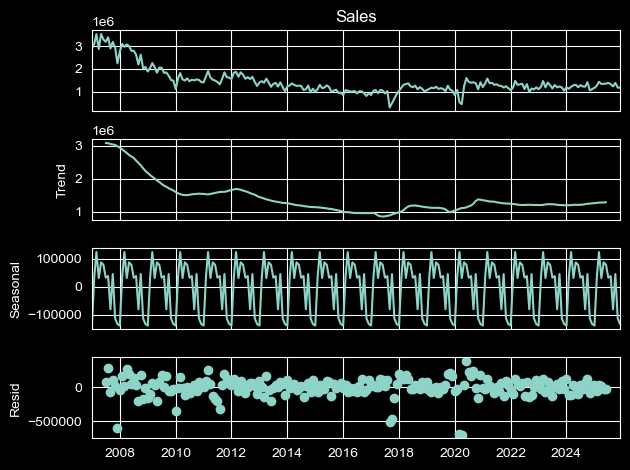

In [23]:
dec = seasonal_decompose(df['Sales'],period = 12, model = 'additive').plot()
plt.show()

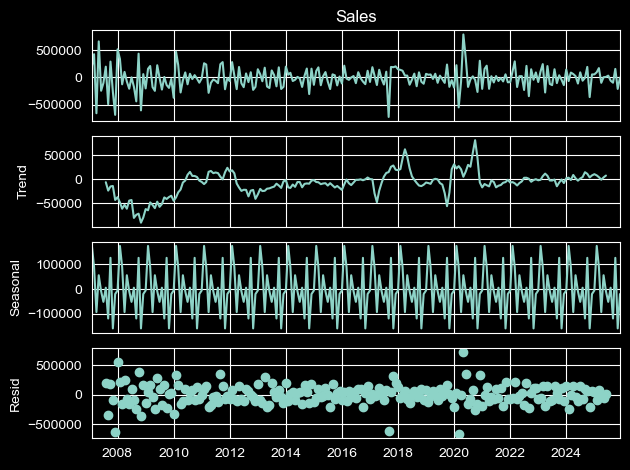

In [24]:
df_diff = df.diff()
df_diff = df_diff.dropna()

dec = seasonal_decompose(df_diff['Sales'],period = 12).plot()
plt.show()

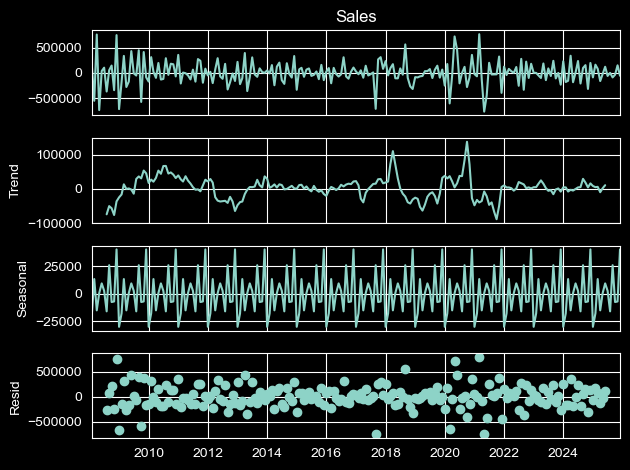

In [25]:
df_diff_seasonal = df_diff.diff(12)
df_diff_seasonal = df_diff_seasonal.dropna()

dec = seasonal_decompose(df_diff_seasonal['Sales'],period = 12).plot()
plt.show()

In [26]:
# ADF test on differenced data
adf_stat_diff, p_value_diff, *_ = adfuller(df_diff_seasonal['Sales'])
print(f'ADF Statistic for differenced data: {adf_stat_diff}')
print(f'p-value for differenced data: {p_value_diff}')

ADF Statistic for differenced data: -5.800149536743633
p-value for differenced data: 4.6514176466427266e-07


#### Interpretation

The ADF test on the differenced data shows a ADF statistics of -5.80 and p value of 4.65e-07, which is less than 0.05, indicating that the differenced series is stationary. This suggests that applying both first-order differencing (d=1) and seasonal differencing (D=1) has successfully transformed the series into a stationary one, making it suitable for modeling with SARIMA. The seasonal decomposition plots also show that the seasonality has been effectively removed after differencing, further confirming the stationarity of the series. I will proceed to fit a SARIMA model to the differenced data and evaluate its performance.

### Find a good value of P and Q to fit a SARIMA model

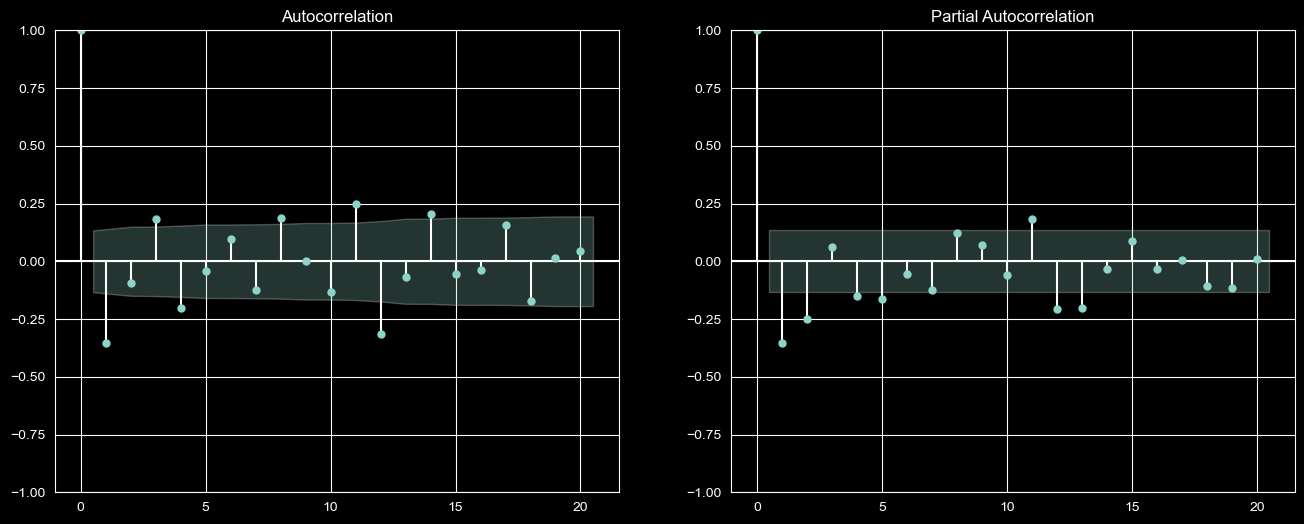

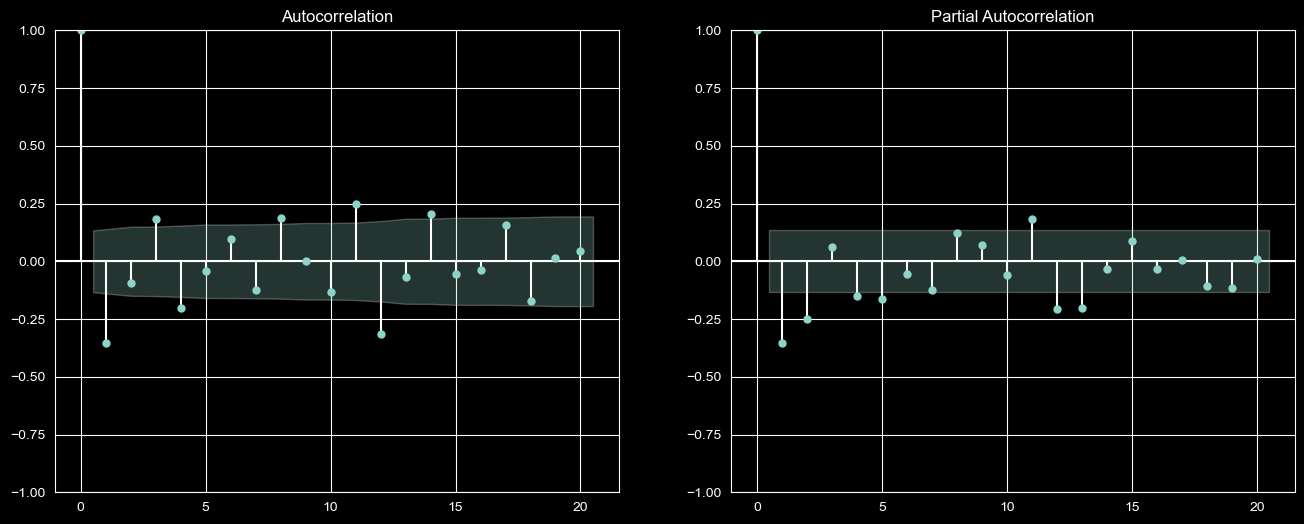

In [27]:
# Plot on diff sales
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_diff_seasonal['Sales'], ax=ax[0], lags=20)
plot_pacf(df_diff_seasonal['Sales'], ax=ax[1], lags=20)


#### Interpretation

The ACF plot of the differenced series shows significant spikes at lags 1 and 12, which suggests that there may be a seasonal MA component (Q=1) in the model. The PACF plot shows a significant spike at lag 1 and then cuts off, which suggests that there may be an AR component (P=1) in the model.

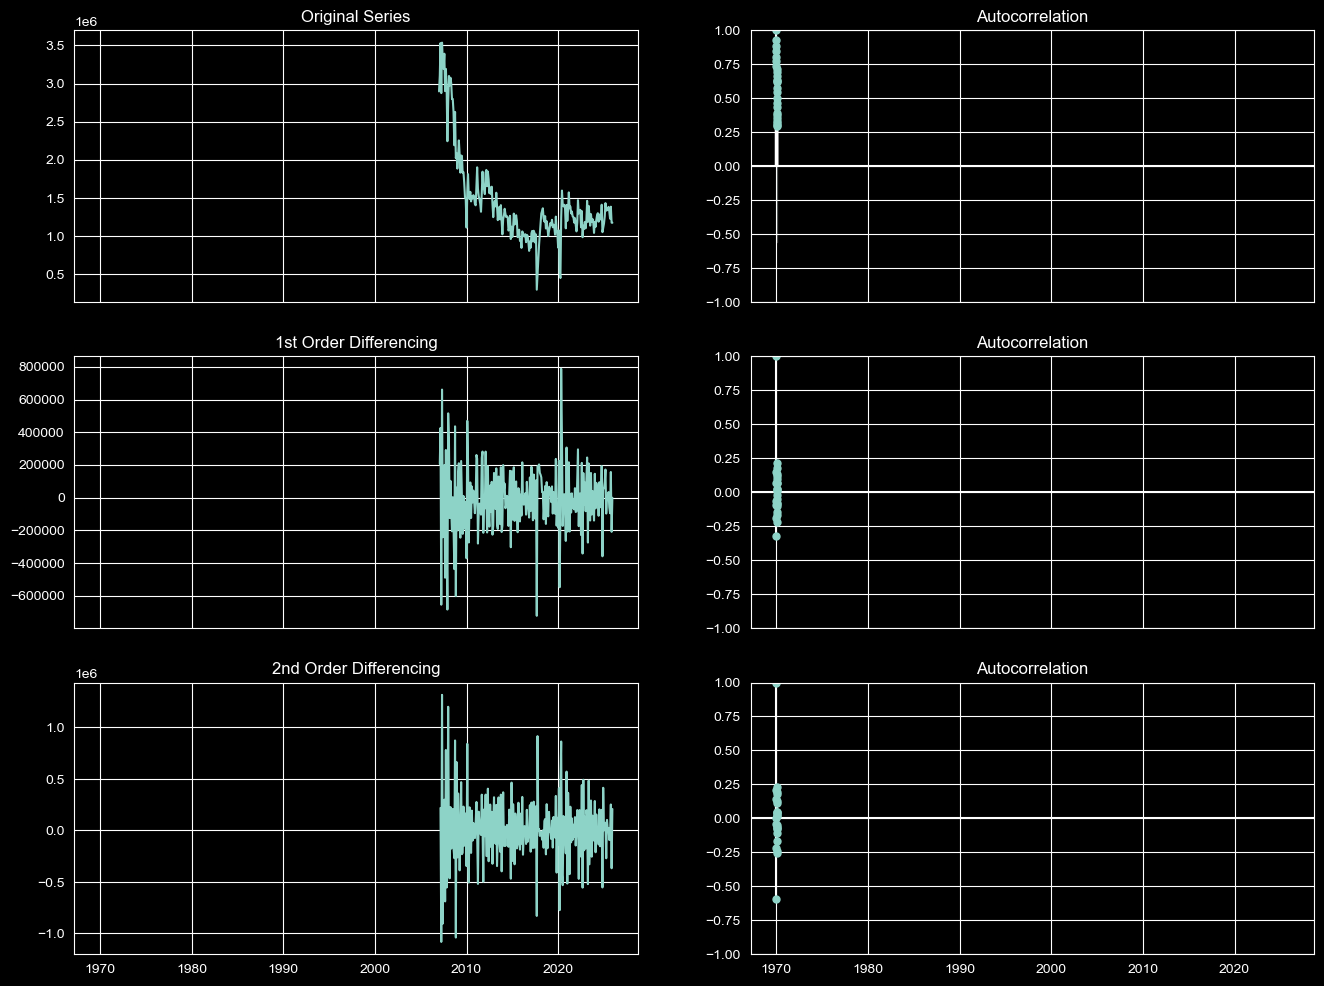

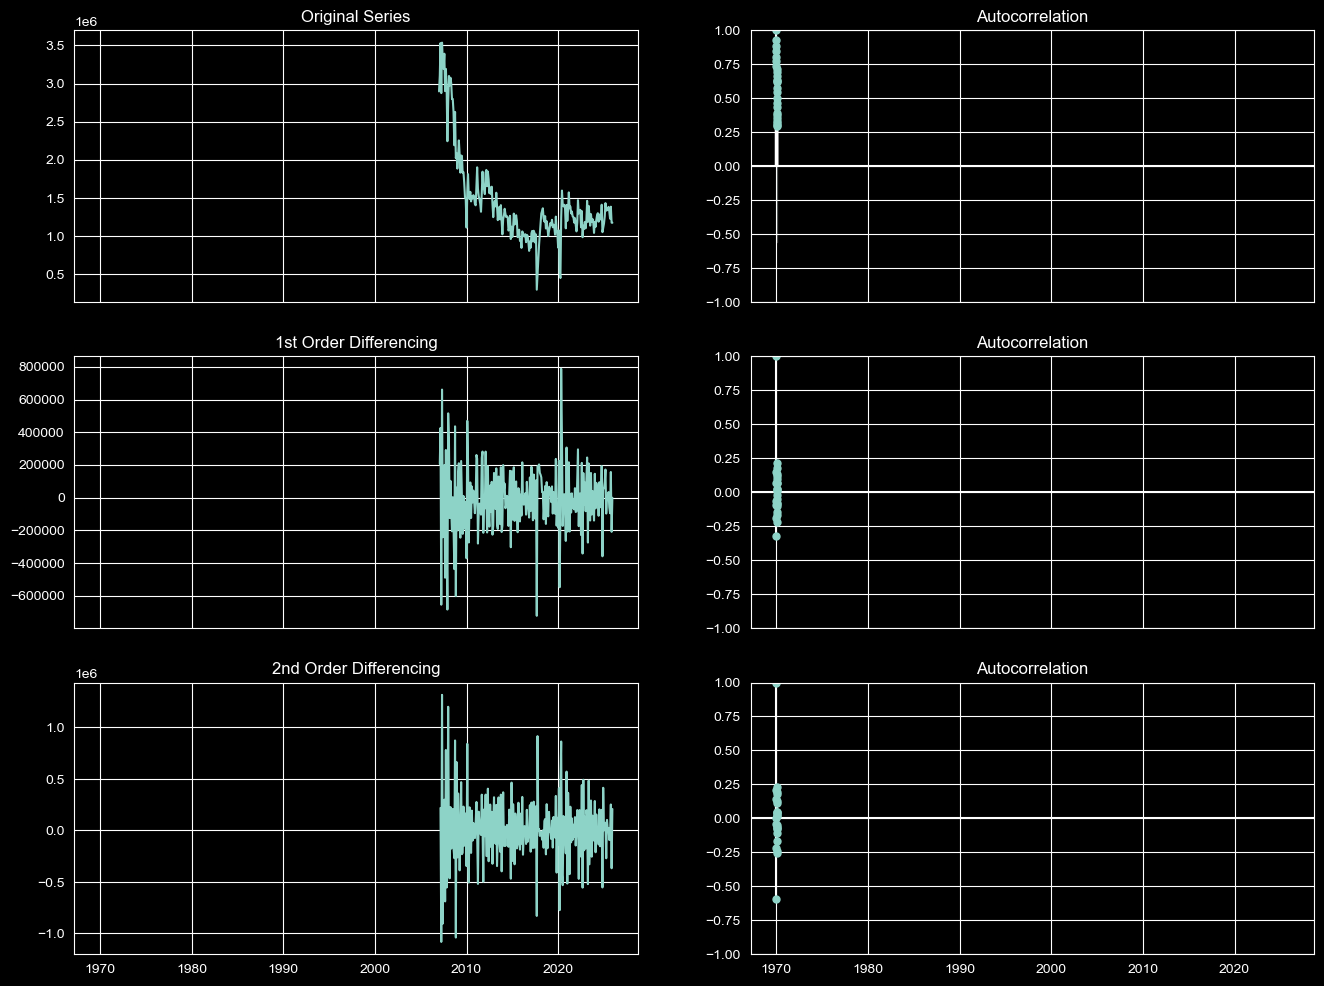

In [28]:
# plotting autocorrelation on diff sales

fig, ax = plt.subplots(3,2, sharex=True, figsize=(16, 12))
ax[0,0].plot(df['Sales'])
ax[0,0].set_title('Original Series')
plot_acf(df['Sales'], ax=ax[0,1])

# 1st Differencing
ax[1,0].plot(df['Sales'].diff()); ax[1,0].set_title('1st Order Differencing')
plot_acf(df['Sales'].diff().dropna(), ax=ax[1,1])

# 2nd Differencing
ax[2,0].plot(df['Sales'].diff().diff()); ax[2,0].set_title('2nd Order Differencing')
plot_acf(df['Sales'].diff().diff().dropna(), ax=ax[2,1])

##### Interpretation

The above plots show the original series and the effects of first and second order differencing on the autocorrelation structure. The original series shows strong autocorrelation at multiple lags, indicating non-stationarity. After first-order differencing, the autocorrelation is reduced, and the series appears to be more stationary. This suggests that a SARIMA model with d=1 may be appropriate for modeling this series.

### Fit SARIMA(1,1,1)(1,1,1)12 model

In [29]:
sarimax_1112_model = SARIMAX(df_train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_1112_result = sarimax_1112_model.fit()
sarimax_1112_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2116.342
Date:                            Wed, 11 Feb 2026   AIC                           4242.685
Time:                                    00:40:39   BIC                           4257.902
Sample:                                01-01-2007   HQIC                          4248.866
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1267      0.179     -0.708      0.479      -0.478       0.224
ma.L1         -0.1327      0.173     -0.769      0.442      -0.471       0.205
ar.S.L12       0.4720      0.054      8.666      0.000       0.365       0.579
ma.S.L12      -0.8995      0.118     -7.598      0.000      -1.132      -0.667
sigma2      4.566e+10   2.78e-12   1.64e+22      0.000    4.57e+10    4.57e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                40.78
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.13
Prob(H) (two-sided):                  0.70   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.44e+37. Standard errors may be unstable.
"""

In [30]:
# Forecast with SARIMA(1,1,1)(1,1,1)12
sarimax_1112_forecast = sarimax_1112_result.get_forecast(steps=len(df_test))
sarimax_1112_forecast_ci = sarimax_1112_forecast.conf_int()
sarimax_1112_forecast_mean = sarimax_1112_forecast.predicted_mean

### Fit SARIMA(1,0,1)(1,0,1)12 model

In [31]:
sarimax_1012_model = SARIMAX(df_train['Sales'], order=(1,0,1), seasonal_order=(1,0,1,12))
sarimax_1012_result = sarimax_1012_model.fit()
sarimax_1012_result.summary()

# Forecast with SARIMA(1,1,1)(1,1,1)12
sarimax_1012_forecast = sarimax_1012_result.get_forecast(steps=len(df_test))
sarimax_1012_forecast_ci = sarimax_1012_forecast.conf_int()
sarimax_1012_forecast_mean = sarimax_1012_forecast.predicted_mean

In [32]:
# Plot testing and forcasting

# Function to plot sales
fig = go.Figure()

# plot train Sales column
fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['Sales'],
    mode='lines+markers',
    name='Train Sales',
    line=dict(color='#636EFA'),
    marker=dict(color='#636EFA')))

# plot test Sales column
fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['Sales'],
    mode='lines+markers',
    name='Test Sales',
    line=dict(color='green'),
    marker=dict(color='green')))

# plot forecast for SARIMAX(1,1,1)(1,1,1)12
fig.add_trace(go.Scatter(
    x=sarimax_1112_forecast_mean.index,
    y=sarimax_1112_forecast_mean,
    mode='lines+markers',
    name='SARIMAX(1,1,1)12 Forecast',
    line=dict(color='red'),
    marker=dict(color='red')))

# plot forecast for SARIMAX(1,0,1)(1,0,1)12
fig.add_trace(go.Scatter(
    x=sarimax_1012_forecast_mean.index,
    y=sarimax_1012_forecast_mean,
    mode='lines+markers',
    name='SARIMAX(1,0,1)12 Forecast',
    line=dict(color='grey'),
    marker=dict(color='grey')))


# plot config
fig.update_layout(
    title='Monthly Sales of Cement Bags in Puerto Rico',
    xaxis_title='Date',
    yaxis_title='Number of Cement Bags Sold',
    template='plotly_white',
    hovermode='x'
)

fig.show()

In [33]:
### Evaluate the forecasts using MSE and MAE

# Calculate MSE and MAE for SARIMA(1,1,1)(1,1,1)12
mse_sarimax_1112 = mean_squared_error(df_test['Sales'], sarimax_1112_forecast_mean)
mae_sarimax_1112 = mean_absolute_error(df_test['Sales'], sarimax_1112_forecast_mean)

# Calculate MSE and MAE for SARIMA(1,0,1)(1,0,1)12
mse_sarimax_1012 = mean_squared_error(df_test['Sales'], sarimax_1012_forecast_mean)
mae_sarimax_1012 = mean_absolute_error(df_test['Sales'], sarimax_1012_forecast_mean)

# Print results

print(f'SARIMA(1,1,1)(1,1,1)12 - MSE: {mse_sarimax_1112:.2f}, MAE: {mae_sarimax_1112:.2f}')

print(f'SARIMA(1,0,1)(1,0,1)12 - MSE: {mse_sarimax_1012:.2f}, MAE: {mae_sarimax_1012:.2f}')



SARIMA(1,1,1)(1,1,1)12 - MSE: 464333192317.13, MAE: 636378.53
SARIMA(1,0,1)(1,0,1)12 - MSE: 20534836137.35, MAE: 121501.91


#### Interpretation

The SARIMA(1,1,1)(1,1,1)12 model has a MSE of 464333192317 and MAE of 636378.  This model seems to be over differencing causing biased forecast and larger errors.


The SARIMA(1,0,1)(1,0,1)12 model has a MSE of 20534836137 and MAE of 20534836137. This model is performing much better than the SARIMA(1,1,1)(1,1,1)12 model, with significantly lower MSE and MAE values. This suggests that the SARIMA(1,0,1)(1,0,1)12 model is a better fit for the data and provides more accurate forecasts for the sales of cement bags in Puerto Rico.

### Prophet Model

In [60]:
# Prepare data for Prophet
prophet_df = df_train.reset_index()[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Verify structure
# print(prophet_df.head())
print(f"Shape: {prophet_df.shape}")
print(f"Columns: {prophet_df.columns.tolist()}")
print(f"Number of duplicate dates: {prophet_df['ds'].duplicated().sum()}")
print(f"Any null values: {prophet_df.isnull().sum().sum()}")

# Create a NEW Prophet model instance (not reusing an old one)
# This ensures we start fresh
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

# Fit the model
prophet_model.fit(prophet_df)

# Make future predictions
future = prophet_model.make_future_dataframe(periods=len(df_test), freq='MS')
prophet_forecast = prophet_model.predict(future)

# Display results
# print("\nForecast for test period:")
# print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(df_test)))

# Calculate metrics on test period
test_predictions = prophet_forecast.iloc[-len(df_test):]['yhat'].values
mse_prophet = mean_squared_error(df_test['Sales'], test_predictions)
mae_prophet = mean_absolute_error(df_test['Sales'], test_predictions)

print(f'\nProphet Model - MSE: {mse_prophet:.2f}, MAE: {mae_prophet:.2f}')

# print(prophet_forecast[-len(df_test):]['ds'].values)

01:50:24 - cmdstanpy - INFO - Chain [1] start processing
01:50:24 - cmdstanpy - INFO - Chain [1] done processing


Shape: (168, 2)
Columns: ['ds', 'y']
Number of duplicate dates: 0
Any null values: 0

Prophet Model - MSE: 11019549596.84, MAE: 82839.50


In [59]:
# Plot testing and forcasting

# Function to plot sales
fig = go.Figure()

# plot train Sales column
fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['Sales'],
    mode='lines+markers',
    name='Train Sales',
    line=dict(color='#636EFA'),
    marker=dict(color='#636EFA')))

# plot test Sales column
fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['Sales'],
    mode='lines+markers',
    name='Test Sales',
    line=dict(color='green'),
    marker=dict(color='green')))


# plot forecast for SARIMAX(1,0,1)(1,0,1)12
fig.add_trace(go.Scatter(
    x=sarimax_1012_forecast_mean.index,
    y=sarimax_1012_forecast_mean,
    mode='lines+markers',
    name='SARIMAX(1,0,1)12 Forecast',
    line=dict(color='grey'),
    marker=dict(color='grey')))

# plot forecast for prophet
fig.add_trace(go.Scatter(
    x=prophet_forecast[-len(df_test):]['ds'].values,
    y=prophet_forecast[-len(df_test):]['yhat'].values,
     mode='lines+markers',
    name='Prophet Forecast',
    line=dict(color='brown'),
    marker=dict(color='brown')))

# plot config
fig.update_layout(
    title='Monthly Sales of Cement Bags in Puerto Rico',
    xaxis_title='Date',
    yaxis_title='Number of Cement Bags Sold',
    template='plotly_white',
    hovermode='x'
)

fig.show()

#### Interpretation

The Prophet model has a MSE of 11019549596 and MAE of 82839. This model is performing better than the SARIMA(1,0,1)(1,0,1)12 model, with significantly lower MSE and MAE values. This suggests that the Prophet model is a better fit for the data and provides more accurate forecasts for the sales of cement bags in Puerto Rico. The Prophet model is able to capture the seasonality and trend in the data more effectively than the SARIMA model, which may explain its superior performance.

### Conclusion

In conclusion, after fitting and evaluating multiple models, the Prophet model emerged as the best performing model for forecasting the sales of cement bags in Puerto Rico. It outperformed both the ARIMA and SARIMA models in terms of MSE and MAE, indicating that it provided more accurate forecasts. The ability of the Prophet model to capture seasonality and trend in the data likely contributed to its superior performance. Therefore, for future forecasting tasks related to this dataset, the Prophet model would be the recommended choice. However, it is important to note that model performance can vary based on the specific characteristics of the data, and it may be beneficial to continue exploring other models or tuning the existing models for further improvement.
